In [1]:
import pandas as pd
import numpy as np
import numpy.random as nrand

import statsmodels.api as sm
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
rcParams_dict = {
    'xtick.bottom': True,
    'patch.edgecolor':'k',
    'patch.force_edgecolor': True,
    'font.size': 15,
    'pdf.fonttype':42,
    'font.family':'Arial',
    'mathtext.fontset':'custom',
    'mathtext.default': 'regular',
    'mathtext.it': 'Arial:italic',
    'mathtext.it': 'Arial:italic',
}
mpl.rcParams.update(rcParams_dict)

In [28]:
# Get true positive rate
def get_TPR(beta, MAF, SR_WT = 0.52, N_rep = 1000, scale = 1):
    
    SR_1M = SR_WT + beta
    SR_2M = SR_WT + 2*beta

    # Total number of participants
    N_Ps = len(df_phe) * scale

    N_sib_Tot = df_phe['N_siblings'].sum() * scale
    N_family_Tot = df_phe['N_family'].sum() * scale

    N_Ps_1M = int(N_Ps * 2*(1-MAF)*MAF)
    N_Ps_2M = int(N_Ps * MAF**2)
    N_Ps_WT = N_Ps - N_Ps_1M - N_Ps_2M 

    res_dict = {
        'P':[],
        't':[],
        'SE':[],
        'BETA':[]
    }
    
    for i in range(N_rep):
        
         # Here we only consider the genetic effect of one side of parents (either paternal or maternal).

        #If the participant is WT
        N_Ps_WT_Parent_WT, N_Ps_WT_Parent_1M= \
            nrand.multinomial(N_Ps_WT,[1-MAF, MAF])

        # If the participant is 1M
        N_Ps_1M_Parent_WT, N_Ps_1M_Parent_1M, N_Ps_1M_Parent_2M = \
            nrand.multinomial(N_Ps_1M ,[0.5*(1-MAF), 0.5, 0.5*MAF])

        #If the participant is WT
        N_Ps_2M_Parent_1M, N_Ps_2M_Parent_2M= \
            nrand.multinomial(N_Ps_2M,[1-MAF, MAF])

        # Sample number of siblings for WT, 1M, and 2M
        N_Ps_WT_Parent_WT_sib, N_Ps_WT_Parent_1M_sib,N_Ps_1M_Parent_WT_sib, \
        N_Ps_1M_Parent_1M_sib, N_Ps_1M_Parent_2M_sib,N_Ps_2M_Parent_1M_sib, \
        N_Ps_2M_Parent_2M_sib = nrand.multinomial(
            N_sib_Tot,
            np.array([N_Ps_WT_Parent_WT, N_Ps_WT_Parent_1M,N_Ps_1M_Parent_WT,
                      N_Ps_1M_Parent_1M, N_Ps_1M_Parent_2M,N_Ps_2M_Parent_1M,
                      N_Ps_2M_Parent_2M])/N_Ps
        )

        N_Ps_WT_sib = N_Ps_WT_Parent_WT_sib + N_Ps_WT_Parent_1M_sib
        N_Ps_1M_sib = N_Ps_1M_Parent_WT_sib + N_Ps_1M_Parent_1M_sib + N_Ps_1M_Parent_2M_sib
        N_Ps_2M_sib = N_Ps_2M_Parent_1M_sib + N_Ps_2M_Parent_2M_sib

        # Sample number of brothers and sisters for WT, 1M, and 2M.
        N_Ps_WT_bro = nrand.binomial(N_Ps_WT_Parent_WT_sib,SR_WT) + nrand.binomial(N_Ps_WT_Parent_1M_sib,SR_1M)
        N_Ps_WT_sis = N_Ps_WT_sib - N_Ps_WT_bro

        N_Ps_1M_bro = nrand.binomial(N_Ps_1M_Parent_WT_sib,SR_WT) + nrand.binomial(N_Ps_1M_Parent_1M_sib,SR_1M) + \
                      nrand.binomial(N_Ps_1M_Parent_2M_sib,SR_2M)
        N_Ps_1M_sis = N_Ps_1M_sib - N_Ps_1M_bro

        N_Ps_2M_bro = nrand.binomial(N_Ps_2M_Parent_1M_sib,SR_1M) + nrand.binomial(N_Ps_2M_Parent_2M_sib,SR_2M)
        N_Ps_2M_sis = N_Ps_2M_sib - N_Ps_2M_bro

        # Weighted Least Square Regression
        X = np.array([0,1,2]).reshape(-1,1)
        X = sm.add_constant(X)
        Y = np.array([N_Ps_WT_bro/N_Ps_WT_sib, N_Ps_1M_bro/N_Ps_1M_sib, N_Ps_2M_bro/N_Ps_2M_sib]).reshape(-1,1)
        Y[np.isnan(Y)] = 0 # avoid the problem of dividing 0.
        
        glm = sm.GLM(
            Y,
            X,
            family=sm.families.Binomial(),
            freq_weights=[N_Ps_WT_sib, N_Ps_1M_sib, N_Ps_2M_sib]
        )
        try:
            res = glm.fit()
        except:
            print(X)
            print(Y)

        res_dict['P'].append(res.pvalues[1])
        res_dict['t'].append(res.tvalues[1])
        res_dict['SE'].append(res.bse[1])
        res_dict['BETA'].append(res.params[1])
        
    TPR = (np.array(res_dict['P'])<5e-8).sum()/len(res_dict['P'])
    return TPR, res_dict

In [5]:
df_phe = pd.read_table('/home/siliang/Public/workspace/4_UKB_merged_files/GWAS/GWAS_adj_extended.phe')
df_phe = df_phe[['IID','N_full_brothers','N_full_sisters','N_males_in_family','N_females_in_family']]

df_dict = pd.read_table('/home/siliang/Public/workspace/4_UKB_merged_files/GWAS/IID_new_old_dict.csv')
df_phe = pd.merge(right=df_dict, left=df_phe, right_on='OLD_IID', left_on='IID')
df_phe['IID'] = df_phe['RAP_IID'] 
df_phe = df_phe.drop(columns=['RAP_IID','OLD_IID'])

sam_df = pd.read_table(f'/home/siliang/Public/workspace/UKB_imp_filtered_SR_RAP/chr21.psam')

target_IID = sam_df['IID']

df_phe = pd.merge(right=df_phe,left=target_IID,on='IID')



In [6]:
df_phe['N_siblings'] = df_phe['N_full_brothers'] + df_phe['N_full_sisters']
df_phe['N_family'] = df_phe['N_males_in_family'] + df_phe['N_females_in_family']

In [30]:
SR_WT = 0.52
beta = 0 # assume the true effect size is 0
N_rep = 10000

p_list_list = []

for MAF in [0.0025, 0.01, 0.1, 0.5]:
#for MAF in [0.5]:
    TPR, res_dict = get_TPR(beta, MAF, SR_WT, N_rep)
    p_list_list.append(res_dict['P'])

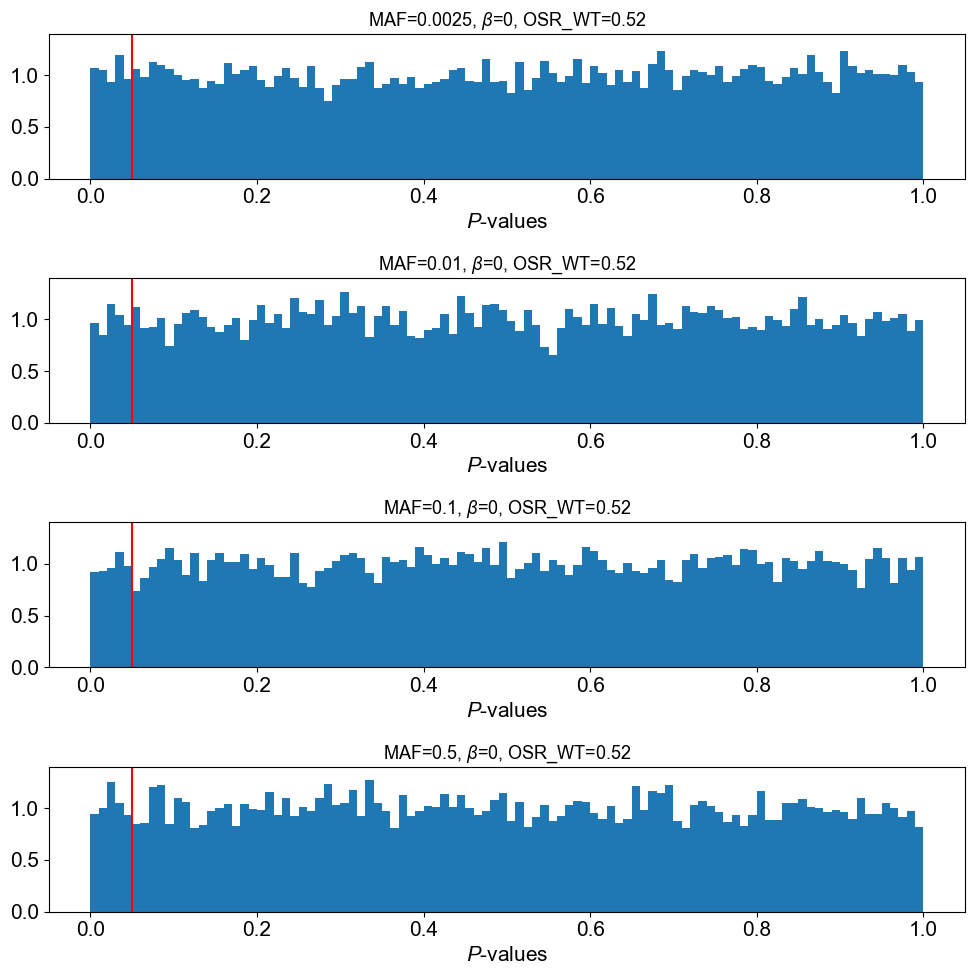

In [63]:
fig, axes = plt.subplots(4, figsize=[10,10])

for i, MAF in enumerate([0.0025, 0.01, 0.1, 0.5]):
    ax = axes[i]
    p_list = p_list_list[i]
    ax.hist(p_list, bins=100, density=True, lw=0, range=[0,1])
    ax.vlines(x=0.05, ymin=0, ymax=1.4, color='r')
    ax.set_xlabel('$\it{P}$-values')
    ax.set_ylim(0, 1.4)
    ax.set_title(f'MAF={MAF}, ' + '$\it{β}$=0, ' + f'OSR_WT={SR_WT}', fontsize=13)
plt.tight_layout()
plt.show()

In [34]:
ax.hist(p_list, bins=100, density=True, lw=0, range=[0,1])

(array([0.94, 1.  , 1.25, 1.05, 0.93, 0.85, 0.86, 1.2 , 1.22, 0.85, 1.1 ,
        1.06, 0.81, 0.84, 0.97, 1.  , 1.04, 0.83, 1.04, 0.99, 0.98, 1.16,
        0.93, 1.1 , 0.92, 1.01, 0.97, 1.1 , 1.23, 1.03, 1.05, 1.18, 0.92,
        1.27, 1.05, 0.97, 0.81, 1.13, 0.92, 0.97, 1.02, 1.01, 1.14, 1.01,
        1.13, 1.  , 0.93, 0.97, 1.08, 1.15, 0.88, 1.06, 0.82, 0.91, 1.03,
        0.88, 0.92, 1.03, 1.07, 1.06, 0.95, 0.9 , 1.02, 0.86, 0.9 , 1.21,
        0.98, 1.17, 1.15, 1.22, 0.88, 0.81, 1.03, 1.07, 1.02, 0.96, 0.87,
        0.93, 0.83, 0.93, 1.17, 0.89, 0.89, 1.05, 1.05, 1.09, 1.01, 1.  ,
        0.96, 0.98, 0.96, 0.9 , 1.1 , 0.94, 0.94, 1.05, 1.  , 0.91, 0.97,
        0.82]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

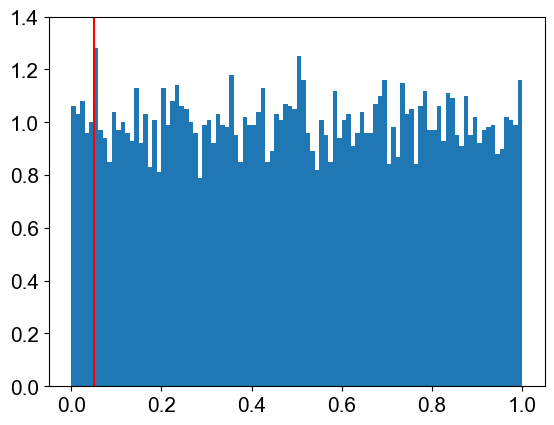

In [25]:
plt.hist(res_dict['P'], bins=100, density=True, lw=0)
plt.vlines(x=0.05, ymin=0, ymax=1.4, color='r')
plt.ylim(0, 1.4)
plt.show()


In [59]:
beta_list = np.linspace(start=0.005,stop=0.2,num=40)
MAF_list = np.linspace(start=0.0025,stop=0.1,num=40)

TPR_res_array = np.zeros(shape=[len(beta_list),len(MAF_list)])
        
for i,beta in enumerate(beta_list):
    print(f'beta: {beta}')
    for j,MAF in enumerate(MAF_list):
        print(f'MAF: {MAF}',flush=True,end='\r')
        TPR_res_array[i,j] = get_TPR(beta, MAF, SR_WT, N_rep, scale=8)
        if TPR_res_array[i,j] == 1:
            TPR_res_array[i,j:] = 1
            break

beta: 0.005
beta: 0.01500000000000015
beta: 0.01500000000000005
beta: 0.02599999999999998
beta: 0.02500000000000001
beta: 0.030000000000000002
beta: 0.034999999999999996
beta: 0.045
beta: 0.045
beta: 0.049999999999999996
beta: 0.055
beta: 0.065
beta: 0.065
beta: 0.075
beta: 0.07500000000000001
beta: 0.085
beta: 0.085
beta: 0.09000000000000001
beta: 0.095
beta: 0.125
beta: 0.10500000000000001
beta: 0.115
beta: 0.115
beta: 0.12000000000000001
beta: 0.125
beta: 0.135
beta: 0.135
beta: 0.145
beta: 0.14500000000000002
beta: 0.155
beta: 0.155
beta: 0.165
beta: 0.165
beta: 0.175
beta: 0.17500000000000002
beta: 0.18000000000000002
beta: 0.185
beta: 0.195
beta: 0.195
beta: 0.225


In [60]:
with open('TPR_res_array_UKB_logistic_8X.pkl','wb') as f:
    pickle.dump(TPR_res_array,f)

In [7]:
beta_list = np.linspace(start=0.005,stop=0.2,num=40)
MAF_list = np.linspace(start=0.0001,stop=0.004,num=40)

TPR_res_array = np.zeros(shape=[len(beta_list),len(MAF_list)])

for i,beta in enumerate(beta_list):
    print(f'beta: {beta}')
    for j,MAF in enumerate(MAF_list):
        print(f'MAF: {MAF}',flush=True,end='\r')
        TPR_res_array[i,j] = get_TPR(beta, MAF, SR_WT, N_rep)
        if TPR_res_array[i,j] == 1:
            TPR_res_array[i,j:] = 1
            break

beta: 0.005
beta: 0.0190000000000000023
beta: 0.0150000000000000023
beta: 0.0290000000000000023
beta: 0.0250000000000000023
beta: 0.0300000000000000023
beta: 0.0349999999999999963
beta: 0.0490000000000000023
beta: 0.0450000000000000023
beta: 0.0499999999999999963
beta: 0.0550000000000000023
beta: 0.0690000000000000023
beta: 0.0650000000000000023
beta: 0.0790000000000000023
beta: 0.0750000000000000123
beta: 0.0890000000000000023
beta: 0.0850000000000000023
beta: 0.0900000000000000123
beta: 0.0950000000000000023
beta: 0.1370000000000000023
beta: 0.1050000000000000123
beta: 0.1190000000000000023
beta: 0.1150000000000000023
beta: 0.1200000000000000123
beta: 0.1250000000000000023
beta: 0.1320000000000000023
beta: 0.1350000000000000023
beta: 0.1490000000000000023
beta: 0.1450000000000000213
beta: 0.1570000000000000013
beta: 0.1550000000000000013
beta: 0.1640000000000000023
beta: 0.1650000000000000023
beta: 0.1750000000000000023
beta: 0.1750000000000000223
beta: 0.1800000000000000213
beta: 0.

In [8]:
# with open('TPR_res_array_UKB_logistic_small_MAF.pkl','wb') as f:
#     pickle.dump(TPR_res_array,f)

In [40]:
with open('TPR_res_array_UKB_logistic_8X.pkl','rb') as f:
    TPR_res_array = pickle.load(f)

In [11]:
np.linspace(start=0.005,stop=0.2,num=40)

array([0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045,
       0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 ,
       0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135,
       0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 ,
       0.185, 0.19 , 0.195, 0.2  ])

In [14]:
int(0.025/0.0025) - 1

19

In [48]:
#beta = 0.035
#MAF = 0.0025

beta = 0.005
MAF = 0.1

row_idx = int(beta/0.005) - 1
column_idx = int(MAF/0.0025) - 1
TPR_res_array[row_idx,column_idx]

0.816

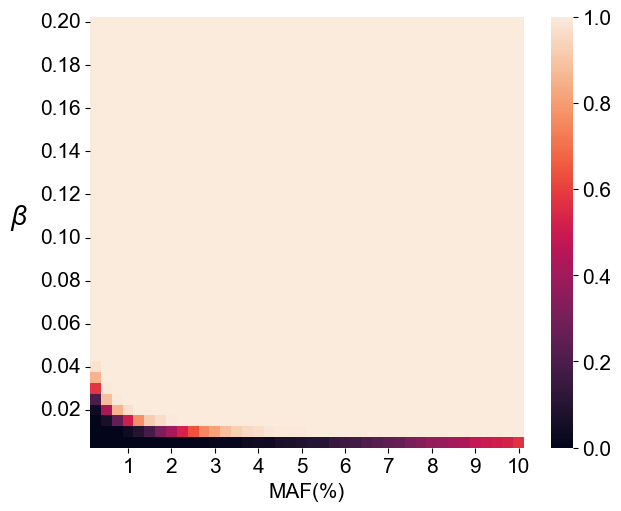

In [61]:
fig,ax = plt.subplots(figsize=[7,5.6])
ax2 = sns.heatmap(TPR_res_array)
ax.set_xticks(ticks=np.linspace(3,39,10)+0.5,
              labels=[f'{MAF*100:.0f}' for MAF in np.linspace(start=0.01,stop=0.1,num=10)],rotation=0,fontsize=15)
ax.set_yticks(ticks=np.linspace(3,39,10)+0.5,
              labels=[f'{beta:.2f}' for beta in np.linspace(start=0.02,stop=0.2,num=10)],rotation=0,fontsize=15)
ax.invert_yaxis()

cbar = ax2.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=15)

ax.set_xlabel('MAF(%)',fontsize=15)
ax.set_ylabel('$\mathit{β}$',fontsize=20,rotation=0,labelpad=15)

plt.savefig('UKB_power_analysis_logistic_8X.pdf')

In [70]:
TPR_res_array[6,0]

0.855

In [34]:
get_TPR(0.097, 0.0025, 0.52, 1000)

0.827

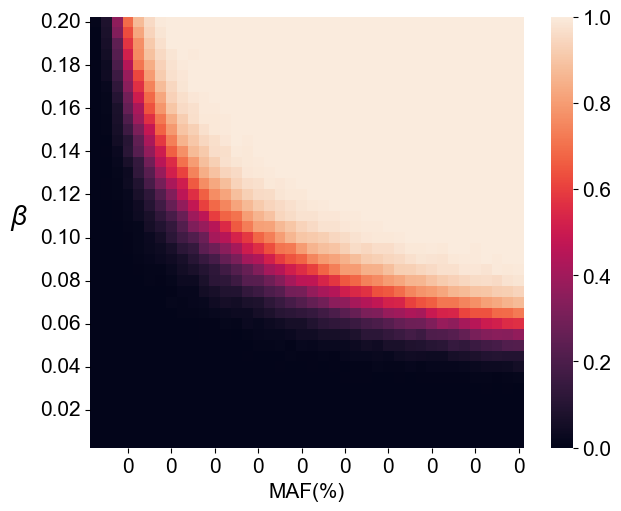

In [9]:
fig,ax = plt.subplots(figsize=[7,5.6])
ax2 = sns.heatmap(TPR_res_array)
ax.set_xticks(ticks=np.linspace(3,39,10)+0.5,
              labels=[f'{MAF*100:.0f}' for MAF in np.linspace(start=0.0004,stop=0.004,num=10)],rotation=0,fontsize=15)
ax.set_yticks(ticks=np.linspace(3,39,10)+0.5,
              labels=[f'{beta:.2f}' for beta in np.linspace(start=0.02,stop=0.2,num=10)],rotation=0,fontsize=15)
ax.invert_yaxis()

cbar = ax2.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=15)

ax.set_xlabel('MAF(%)',fontsize=15)
ax.set_ylabel('$\mathit{β}$',fontsize=20,rotation=0,labelpad=15)

plt.savefig('UKB_power_analysis_logistic_small_MAF.pdf')